## LSTM

In [ ]:
!pip install datapackage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.8 MB/s eta 0:00:00
  Created wheel for unicodecsv: filename=unicodecsv-0.14.1-py3-none-any.whl size=10745 sha256=6ecd553c81ca87a55e944cca24b6d105607c96a8f69f54af64996db719b722dd
  Stored in directory: /root/.cache/pip/wheels/9c/ea/66/8e45247b09052a933eb1a680b7c64802298faba58aac9b346b
  Created

In [ ]:
import pandas as pd

#Vamos ver como funcionam as LSTM
#Para estudar as Redes Long Short Term Memory vamos precisar de séries temporais

from datapackage import Package # a biblioteca datapackage oferece uma coleção de dados que podem ser baixados diretamente da internet

package = Package('https://datahub.io/core/global-temp/datapackage.json') # vamos carregar a base com as médias de temperatura global ao longo dos últimos anos

for resource in package.resources: # de todos os recursos disponíveis no pacote autor, informações, etc
    if resource.descriptor['datahub']['type'] == 'derived/csv': #vamos selecionar o arquivo CSV para carregá-lo
        data = resource.read()

data_gcag = data[0:len(data):2][::-1]

df_gcag = pd.DataFrame(data_gcag, columns=['GCAG','Year', 'Mean Temperature'])

df_gcag.head()


,GCAG,Year,Mean Temperature
0,GCAG,1880-01-06,0.0009
1,GCAG,1880-02-06,-0.1229
2,GCAG,1880-03-06,-0.1357
3,GCAG,1880-04-06,-0.0499
4,GCAG,1880-05-06,-0.0738


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

Y = np.zeros(shape=(len(data_gcag), 1), dtype=np.float32)

for i, y in enumerate(data_gcag):
    Y[i - 1, 0] = y[2] #valores de Y serão preenchidos sequencialmente com os valores da coluna 2(temperatura media) de data_gcag

mmscaler = MinMaxScaler((-1.0, 1.0))
Y = mmscaler.fit_transform(Y)  #vamos transformar os dados para escala -1 e 1

df_gcag = pd.DataFrame(Y, columns=['Mean Temperature'])

display(df_gcag)


,Mean Temperature
0,-0.415262
1,-0.428706
2,-0.338585
3,-0.363689
4,-0.463894
...,...
1639,0.634683
1640,0.479754
1641,0.502022
1642,0.543091


In [ ]:
nb_samples = 1600      #são 1600 linhas
nb_test_samples = 200  #estamos separando as últimas 200 para teste
sequence_length = 20   #janela que será usada para prever o próximo valor.

# matrizes X_ts e Y_ts com formatos adequados para armazenar as amostras e os rótulos(saídas) das séries temporais.
X_ts = np.zeros(shape=(nb_samples - sequence_length, sequence_length, 1), dtype=np.float32)
Y_ts = np.zeros(shape=(nb_samples - sequence_length, 1), dtype=np.float32)

#cria pares de sequências de entrada e saída correspondentes para o modelo de previsão de séries temporais.
#Os 20 primeiros valores é a amostra de entrada (X_ts) e o 21° valor é o valor a ser predito de saida (Y_ts)
for i in range(0, nb_samples - sequence_length):
    X_ts[i] = Y[i:i + sequence_length]  #Entrada -> pega os valores de 0 até 19
    Y_ts[i] = Y[i + sequence_length]     #Saida -> pega o vigesimo valor a ser predito

#prepara o conjunto de treinamento e teste para serem usados em um modelo de previsão de séries temporais.
X_ts_train = X_ts[0:nb_samples - nb_test_samples, :]
Y_ts_train = Y_ts[0:nb_samples - nb_test_samples]

X_ts_test = X_ts[nb_samples - nb_test_samples:, :]
Y_ts_test = Y_ts[nb_samples - nb_test_samples:]


In [ ]:
from keras.models import Sequential #permite adicionar camadas sequencialmente.
from keras.layers import LSTM, Dense, Activation,Flatten

model = Sequential() # vamos criar um modelo sequencial p/ a rede neural

#Quando uma LSTM é seguida por outra camada LSTM, a primeira deve ter o parâmetro return_sequences=True.
#model.add(LSTM(8, stateful=True, return_sequences=True, batch_input_shape=(20, sequence_length, 1)))

#stateful=True indica que as conexões de estado serão mantidas entre os batches de treinamento.
#Uma unidade (8 unidades abaixo) em uma camada LSTM representa um bloco de processamento que contém células de memória, portões de entrada, portões de esquecimento e portões de saída. Cada unidade é responsável por armazenar e atualizar informações de estado ao longo do tempo, permitindo que a rede neural aprenda dependências de longo prazo em sequências.
#define um bloco LSTM com 8 unidades (blocos)
#batch_input_shape: define o formato do lote de entrada, com dimensões (20, sequence_length, 1), indicando que cada lote terá 20 sequências
#de tamanho sequence_length, com 1 valor em cada sequência.
model.add(LSTM(8, stateful=True, batch_input_shape=(20, sequence_length, 1)))
model.add(Flatten()) # a saída é transformada em um único vetor de entrada
model.add(Dense(1))  # para um único perceptron
model.add(Activation('linear')) #com ativação linear

Compila a rede neural com o otimizador Adam, usando uma taxa de aprendizado de 0.001 e uma taxa de decaimento (decay) de 0.0001.
A função de perda ou métrica usada é o MSE (Mean Squared Error). É uma forma de quantificar o quão próximo as previsões estão dos valores reais.
A métrica MSE é comumente utilizada em problemas de regressão, nos quais o objetivo é prever um valor numérico contínuo. Ela mede a média dos erros ao quadrado entre as previsões do modelo e os valores reais.

In [ ]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001, decay=0.0001), #treinada com taxa de aprendizado 0.001
              loss='mse', # e função de perda/métrica MSE
              metrics=['mse'])

In [ ]:
# vamos executar o treinamento

history = model.fit(X_ts_train, Y_ts_train,
          batch_size=20, #para lotes de 20 em 20
          epochs=100, # por 100 épocas
          shuffle=False, #sem embaralhar os dados de treinamento a cada época
          validation_data=(X_ts_test, Y_ts_test)) #fazendo a validação com o conjunto separado para testes


Epoch 1/100
70/70 [==============================] - 3s 16ms/step - loss: 0.0728 - mse: 0.0728 - val_loss: 0.1210 - val_mse: 0.1210
Epoch 2/100
70/70 [==============================] - 1s 8ms/step - loss: 0.0245 - mse: 0.0245 - val_loss: 0.0934 - val_mse: 0.0934
Epoch 3/100
70/70 [==============================] - 1s 8ms/step - loss: 0.0186 - mse: 0.0186 - val_loss: 0.0695 - val_mse: 0.0695
Epoch 4/100
70/70 [==============================] - 1s 8ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0537 - val_mse: 0.0537
Epoch 5/100
70/70 [==============================] - 1s 9ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0440 - val_mse: 0.0440
Epoch 6/100
70/70 [==============================] - 1s 18ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0381 - val_mse: 0.0381
Epoch 7/100
70/70 [==============================] - 1s 11ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0344 - val_mse: 0.0344
Epoch 8/100
70/70 [==============================] - 1s 8ms/step - loss: 0.0130 

Loss ou função de perda é uma medida utilizada durante o treinamento do modelo para ajustar os pesos dos neurônios e otimizar a rede neural. A função de perda representa o erro entre as previsões do modelo e os valores reais, e seu objetivo é ser minimizada durante o treinamento.
MSE é uma métrica de avaliação que calcula o erro médio ao quadrado entre as previsões do modelo e os valores reais. Ela é usada para medir o desempenho do modelo em problemas de regressão, onde o objetivo é prever um valor numérico contínuo. O MSE é calculado como a média dos quadrados das diferenças entre cada previsão e o valor real correspondente.
Em resumo, MSE é uma métrica de avaliação que calcula o erro médio ao quadrado, enquanto Loss é uma função utilizada para otimizar o modelo durante o treinamento. O MSE pode ser usado tanto como métrica quanto como função de perda, dependendo do contexto em que é aplicado.

In [ ]:
import matplotlib.pyplot as plt

# lista todos os dados contidos no histórico de treinamento
print(history.history.keys())

# plotamos o erro calculado a partir do histórico
plt.plot(history.history['mse'])  # erro médio quadrático (treinamento)
plt.plot(history.history['val_mse']) # erro médio quadrático (teste)
plt.title('MSE do Modelo')
plt.ylabel('mse')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc='upper left')
plt.show()

# plotamos o erro/perda a partir do histórico
plt.plot(history.history['loss']) # perda/erro durante o treinamento
plt.plot(history.history['val_loss']) #perda/erro durante a validação (teste)
plt.title('Perda do modelo')
plt.ylabel('perda')
plt.xlabel('época')
plt.legend(['treino', 'teste'], loc='upper left')
plt.show()




70/70 [==============================] - 1s 3ms/step


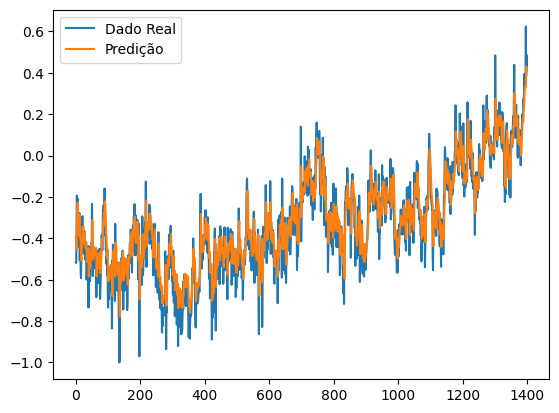

In [ ]:
# Agora, vamos visualizar os dados reais vs os dados calculados na predição (usando os dados de treinamento)
plt.plot(Y_ts_train)
plt.plot(model.predict(X_ts_train, batch_size=20))
plt.legend(['Dado Real', 'Predição'], loc='upper left')
plt.show()

9/9 [==============================] - 0s 3ms/step


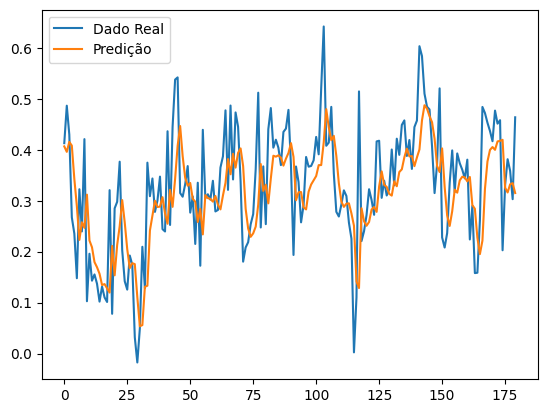

In [ ]:
# e vamos visualizar os dados reais vs os dados calculados na predição (usando os dados de validação)
plt.plot(Y_ts_test)
plt.plot(model.predict(X_ts_test, batch_size=20))
plt.legend(['Dado Real', 'Predição'], loc='upper left')
plt.show()

## Autoencoder
Não supervisionado

### Standard Autoencoder Não supervisionado


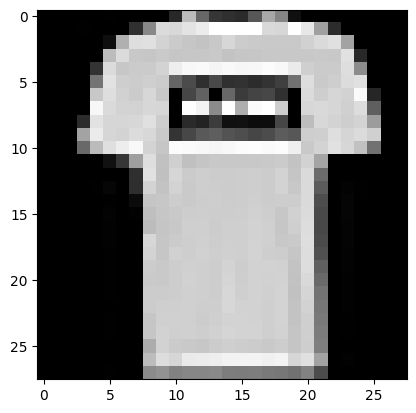

In [28]:
import numpy as np
from PIL import Image

from keras.datasets import fashion_mnist

(X_train, _), (_, _) = fashion_mnist.load_data()

nb_samples = 1000
nb_epochs = 400
batch_size = 200
code_length = 256

X_train = X_train.astype(np.float32)[0:nb_samples] / 255.0

width = X_train.shape[1]
height = X_train.shape[2]

plt.imshow(X_train[1], cmap="gray")

In [ ]:
from keras.layers import Dense, Flatten, Conv2D,Conv2DTranspose
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

graph = tf.Graph()

with graph.as_default():
    input_images = tf.placeholder(tf.float32, shape=(None, width, height, 1))

    r_input_images = tf.image.resize_images(input_images, (32, 32))

    # Encoder
    conv_0 = Conv2D(filters=32,
                      kernel_size=(3, 3),
                      strides=(2, 2),
                      activation=tf.nn.relu,
                      padding='same')(r_input_images)

    conv_1 = Conv2D(filters=64,
                      kernel_size=(3, 3),
                      activation=tf.nn.relu,
                      padding='same')(conv_0)

    conv_2 = Conv2D(filters=128,
                      kernel_size=(3, 3),
                      activation=tf.nn.relu,
                      padding='same')(conv_1)

    # Code layer
    code_input = Flatten()(conv_2)

    code_layer = Dense(units=code_length,
                         activation=tf.nn.sigmoid)(code_input)

    # Decoder
    decoder_input = tf.reshape(code_layer, (-1, 16, 16, 1))

    convt_0 = Conv2DTranspose(filters=128,
                                 kernel_size=(3, 3),
                                 strides=(2, 2),
                                 activation=tf.nn.relu,
                                 padding='same')(decoder_input)

    convt_1 = Conv2DTranspose(filters=64,
                                 kernel_size=(3, 3),
                                 activation=tf.nn.relu,
                                 padding='same')(convt_0)

    convt_2 = Conv2DTranspose(filters=32,
                                 kernel_size=(3, 3),
                                 activation=tf.nn.relu,
                                 padding='same')(convt_1)

    convt_3 = Conv2DTranspose(filters=1,
                                 kernel_size=(3, 3),
                                 activation=tf.sigmoid,
                                 padding='same')(convt_2)

    # Loss
    loss = tf.nn.l2_loss(convt_3 - r_input_images)

    # Training step
    training_step = tf.train.AdamOptimizer(0.001).minimize(loss)

In [25]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

session = tf.InteractiveSession(graph=graph)
tf.global_variables_initializer().run()

for e in range(nb_epochs):
    np.random.shuffle(X_train)

    total_loss = 0.0

    for i in range(0, nb_samples - batch_size, batch_size):
        X = np.zeros((batch_size, width, height, 1), dtype=np.float32)
        X[:, :, :, 0] = X_train[i:i + batch_size, :, :]

        _, n_loss = session.run([training_step, loss],
                                feed_dict={
                                    input_images: X
                                })
        total_loss += n_loss

    print('Epoch {}) Total loss: {}'.format(e + 1, total_loss))

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch 1) Total loss: 57112.033203125
Epoch 2) Total loss: 38061.3505859375
Epoch 3) Total loss: 34543.716796875
Epoch 4) Total loss: 31153.77099609375
Epoch 5) Total loss: 30646.9482421875
Epoch 6) Total loss: 29641.2080078125
Epoch 7) Total loss: 28780.8544921875
Epoch 8) Total loss: 28163.60302734375
Epoch 9) Total loss: 27364.41748046875
Epoch 10) Total loss: 26359.2578125
Epoch 11) Total loss: 25407.69775390625
Epoch 12) Total loss: 23987.7763671875
Epoch 13) Total loss: 22009.9541015625
Epoch 14) Total loss: 20499.7314453125
Epoch 15) Total loss: 20113.85400390625
Epoch 16) Total loss: 18608.400390625
Epoch 17) Total loss: 17976.14013671875
Epoch 18) Total loss: 16854.400634765625
Epoch 19) Total loss: 16303.0283203125
Epoch 20) Total loss: 15767.921875
Epoch 21) Total loss: 15087.5771484375
Epoch 22) Total loss: 14576.270263671875
Epoch 23) Total loss: 14133.46728515625
Epoch 24) Total loss: 13724.697021484375
Epoch 25) Total loss: 13412.957763671875
Epoch 26) Total loss: 12994.9

KeyboardInterrupt: ignored

In [ ]:
import numpy as np

codes = session.run([code_layer],
                    feed_dict={
                        input_images: np.expand_dims(X_train, axis=3),
                    })[0]

print(np.mean(codes))

0.5324642


In [ ]:
import numpy as np

Xs = np.reshape(X_train[0:10], (10, width, height, 1))

Ys = session.run([convt_3],
                 feed_dict={
                     input_images: Xs
                })

Ys = np.squeeze(Ys[0] * 255.0)

In [ ]:
    for i in range(0,10):
        im = Image.fromarray(X_train[i] * 255.0)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        IPython.display.display(im)

        im = Image.fromarray(Ys[i])
        if im.mode != 'RGB':
            im = im.convert('RGB')
        IPython.display.display(im)

### denoising autoencoder

In [26]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

graph = tf.Graph()

with graph.as_default():
    input_noisy_images = tf.placeholder(tf.float32, shape=(None, width, height, 1))
    input_images = tf.placeholder(tf.float32, shape=(None, width, height, 1))

    # Encoder
    conv_0 = Conv2D(filters=32,
                      kernel_size=(3, 3),
                      activation=tf.nn.relu,
                      padding='same')(input_noisy_images)

    conv_1 = Conv2D(filters=64,
                      kernel_size=(3, 3),
                      activation=tf.nn.relu,
                      padding='same')(conv_0)

    conv_2 = Conv2D(filters=128,
                      kernel_size=(3, 3),
                      activation=tf.nn.relu,
                      padding='same')(conv_1)

    # Code layer
    code_input = Flatten()(conv_2)

    code_layer = Dense(units=width * height,
                         activation=tf.nn.sigmoid)(code_input)
    # Decoder
    decoder_input = tf.reshape(code_layer, (-1, width, height, 1))

    convt_0 = Conv2DTranspose(filters=128,
                                 kernel_size=(3, 3),
                                 activation=tf.nn.relu,
                                 padding='same')(decoder_input)

    convt_1 = Conv2DTranspose(filters=64,
                                 kernel_size=(3, 3),
                                 activation=tf.nn.relu,
                                 padding='same')(convt_0)

    convt_2 = Conv2DTranspose(filters=32,
                                 kernel_size=(3, 3),
                                 activation=tf.nn.relu,
                                 padding='same')(convt_1)

    convt_3 = Conv2DTranspose(filters=1,
                                 kernel_size=(3, 3),
                                 activation=tf.sigmoid,
                                 padding='same')(convt_2)

    # Loss
    loss = tf.nn.l2_loss(convt_3 - input_images)

    # Training step
    training_step = tf.train.AdamOptimizer(0.001).minimize(loss)

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


session = tf.InteractiveSession(graph=graph)
tf.global_variables_initializer().run()

for e in range(nb_epochs):
    total_loss = 0.0

    for i in range(0, nb_samples - batch_size, batch_size):
        X = np.zeros((batch_size, width, height, 1), dtype=np.float32)
        X[:, :, :, 0] = X_train[i:i + batch_size, :, :]
        Xn = np.clip(X + np.random.normal(0.0, 0.2, size=(batch_size, width, height, 1)), 0.0, 1.0)

        _, n_loss = session.run([training_step, loss],
                                feed_dict={
                                    input_images: X,
                                    input_noisy_images: Xn
                                })
        total_loss += n_loss

    print('Epoch {}) Total loss: {}'.format(e + 1, total_loss))

Epoch 1) Total loss: 45172.6357421875
Epoch 2) Total loss: 32639.70751953125


KeyboardInterrupt: 

In [ ]:
import numpy as np


#Generate Noisy dataset
X = np.zeros((len(X_train), width, height, 1), dtype=np.float32)
X[:, :, :, 0] = X_train
Xn = np.clip(X + np.random.normal(0.0, 0.2, size=(len(X), width, height, 1)), 0.0, 1.0)


codes = session.run([code_layer],
                    feed_dict={
                        input_noisy_images: Xn
                    })[0]

print(np.mean(codes))

0.6577547


In [ ]:
import numpy as np

Xs = np.reshape(Xn[0:10], (10, width, height, 1))

Ys = session.run([convt_3],
                 feed_dict={
                     input_noisy_images: Xs
                })

Ys = np.squeeze(Ys[0] * 255.0)

In [ ]:
for i in range(0,10):
    im = Image.fromarray(X_train[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)

    im = Image.fromarray(Ys[i])
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)

### Sparse autoencoder

In [ ]:
import numpy as np

from keras.datasets import fashion_mnist

(X_train, _), (_, _) = fashion_mnist.load_data()

nb_samples = 1000
nb_epochs = 400
batch_size = 200
code_length = 256

X_train = X_train.astype(np.float32)[0:nb_samples] / 255.0

width = X_train.shape[1]
height = X_train.shape[2]

In [ ]:
from keras.layers import Dense, Flatten, Conv2D,Conv2DTranspose
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

graph = tf.Graph()

with graph.as_default():
    input_images = tf.placeholder(tf.float32, shape=(None, width, height, 1))

    r_input_images = tf.image.resize_images(input_images, (32, 32))

    # Encoder
    conv_0 = Conv2D(filters=32,
                      kernel_size=(3, 3),
                      strides=(2, 2),
                      activation=tf.nn.relu,
                      padding='same')(r_input_images)

    conv_1 = Conv2D(filters=64,
                      kernel_size=(3, 3),
                      activation=tf.nn.relu,
                      padding='same')(conv_0)

    conv_2 = Conv2D(filters=128,
                      kernel_size=(3, 3),
                      activation=tf.nn.relu,
                      padding='same')(conv_1)

    # Code layer
    code_input = Flatten()(conv_2)

    code_layer = Dense(units=code_length,
                         activation=tf.nn.sigmoid)(code_input)

    # Decoder
    decoder_input = tf.reshape(code_layer, (-1, 16, 16, 1))

    convt_0 = Conv2DTranspose(filters=128,
                                 kernel_size=(3, 3),
                                 strides=(2, 2),
                                 activation=tf.nn.relu,
                                 padding='same')(decoder_input)

    convt_1 = Conv2DTranspose(filters=64,
                                 kernel_size=(3, 3),
                                 activation=tf.nn.relu,
                                 padding='same')(convt_0)

    convt_2 = Conv2DTranspose(filters=32,
                                 kernel_size=(3, 3),
                                 activation=tf.nn.relu,
                                 padding='same')(convt_1)

    convt_3 = Conv2DTranspose(filters=1,
                                 kernel_size=(3, 3),
                                 activation=tf.sigmoid,
                                 padding='same')(convt_2)

    # Loss
    sparsity_constraint = tf.reduce_sum(0.001 * tf.norm(code_layer, ord=1, axis=1))
    loss = tf.nn.l2_loss(convt_3 - r_input_images) + sparsity_constraint


    # Training step
    training_step = tf.train.AdamOptimizer(0.001).minimize(loss)

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

session = tf.InteractiveSession(graph=graph)
tf.global_variables_initializer().run()

for e in range(nb_epochs):
    np.random.shuffle(X_train)

    total_loss = 0.0

    for i in range(0, nb_samples - batch_size, batch_size):
        X = np.zeros((batch_size, width, height, 1), dtype=np.float32)
        X[:, :, :, 0] = X_train[i:i + batch_size, :, :]

        _, n_loss = session.run([training_step, loss],
                                feed_dict={
                                    input_images: X
                                })
        total_loss += n_loss

    print('Epoch {}) Total loss: {}'.format(e + 1, total_loss))

Epoch 1) Total loss: 60323.5048828125
Epoch 2) Total loss: 39640.9921875
Epoch 3) Total loss: 36335.1806640625


KeyboardInterrupt: 

In [ ]:
import numpy as np

codes = session.run([code_layer],
                    feed_dict={
                        input_images: np.expand_dims(X_train, axis=3),
                    })[0]

print(np.mean(codes))

0.61094445


In [ ]:
import numpy as np

Xs = np.reshape(X_train[0:10], (10, width, height, 1))

Ys = session.run([convt_3],
                 feed_dict={
                     input_images: Xs
                })

Ys = np.squeeze(Ys[0] * 255.0)

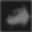

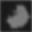

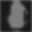

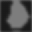

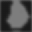

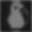

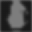

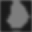

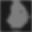

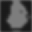

In [ ]:
for i in range(0,10):
    im = Image.fromarray(X_train[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)

    im = Image.fromarray(Ys[i])
    if im.mode != 'RGB':
        im = im.convert('RGB')
    IPython.display.display(im)

### GAN

In [ ]:
import numpy as np

from keras.datasets import fashion_mnist

nb_samples = 5000

(X_train, _), (_, _) = fashion_mnist.load_data()
X_train = X_train.astype(np.float32)[0:nb_samples] / 255.0
X_train = (2.0 * X_train) - 1.0

width = X_train.shape[1]
height = X_train.shape[2]

#### DCGAN

In [ ]:
import tensorflow as tf
from keras.layers import Dense, Flatten, Conv2D,Conv2DTranspose, BatchNormalization

def generator(z, is_training=True):
    with tf.variable_scope('generator'):
        conv_0 = Conv2DTranspose(filters=1024,
                                            kernel_size=(4, 4),
                                            padding='valid')(z)

        b_conv_0 = BatchNormalization()(conv_0,training=is_training)

        conv_1 = Conv2DTranspose(filters=512,
                                            kernel_size=(4, 4),
                                            strides=(2, 2),
                                            padding='same')(tf.nn.leaky_relu(b_conv_0))

        b_conv_1 = BatchNormalization()(conv_1,training=is_training)

        conv_2 = Conv2DTranspose(filters=256,
                                            kernel_size=(4, 4),
                                            strides=(2, 2),
                                            padding='same')(tf.nn.leaky_relu(b_conv_1))

        b_conv_2 = BatchNormalization()(conv_2,training=is_training)

        conv_3 = Conv2DTranspose(filters=128,
                                            kernel_size=(4, 4),
                                            strides=(2, 2),
                                            padding='same')(tf.nn.leaky_relu(b_conv_2))

        b_conv_3 = BatchNormalization()(conv_3,training=is_training)

        conv_4 = Conv2DTranspose(filters=1,
                                            kernel_size=(4, 4),
                                            strides=(2, 2),
                                            padding='same')(tf.nn.leaky_relu(b_conv_3))

        return tf.nn.tanh(conv_4)

In [ ]:
import tensorflow as tf
from keras.layers import Dense, Flatten, Conv2D,Conv2DTranspose, BatchNormalization

def discriminator(x, is_training=True, reuse_variables=True):
    with tf.variable_scope('discriminator', reuse=reuse_variables):
        conv_0 = Conv2D(filters=128,
                                  kernel_size=(4, 4),
                                  strides=(2, 2),
                                  padding='same')(x)

        conv_1 = Conv2D(filters=256,
                                  kernel_size=(4, 4),
                                  strides=(2, 2),
                                  padding='same')(tf.nn.leaky_relu(conv_0))

        b_conv_1 = BatchNormalization()(conv_1, training=is_training)

        conv_2 = Conv2D(filters=512,
                                  kernel_size=(4, 4),
                                  strides=(2, 2),
                                  padding='same')(tf.nn.leaky_relu(b_conv_1))

        b_conv_2 = BatchNormalization()(conv_2, training=is_training)

        conv_3 = Conv2D(filters=1024,
                                  kernel_size=(4, 4),
                                  strides=(2, 2),
                                  padding='same')(tf.nn.leaky_relu(b_conv_2))

        b_conv_3 = BatchNormalization()(conv_3, training=is_training)

        conv_4 = Conv2D(filters=1,
                                  kernel_size=(4, 4),
                                  padding='valid')(tf.nn.leaky_relu(b_conv_3))

        return conv_4

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

code_length = 100

graph = tf.Graph()

with graph.as_default():
    input_x = tf.placeholder(tf.float32, shape=(None, width, height, 1))
    input_z = tf.placeholder(tf.float32, shape=(None, code_length))
    is_training = tf.placeholder(tf.bool)

    gen = generator(z=tf.reshape(input_z, (-1, 1, 1, code_length)), is_training=is_training)

    r_input_x = tf.image.resize_images(images=input_x, size=(64, 64))

    discr_1_l = discriminator(x=r_input_x, is_training=is_training, reuse_variables=False)
    discr_2_l = discriminator(x=gen, is_training=is_training, reuse_variables=True)

    loss_d_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(discr_1_l), logits=discr_1_l))
    loss_d_2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(discr_2_l), logits=discr_2_l))
    loss_d = loss_d_1 + loss_d_2

    loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(discr_2_l), logits=discr_2_l))

    variables_g = [variable for variable in tf.trainable_variables() if variable.name.startswith('generator')]
    variables_d = [variable for variable in tf.trainable_variables() if variable.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        training_step_d = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(loss=loss_d, var_list=variables_d)
        training_step_g = tf.train.AdamOptimizer(0.0002, beta1=0.5).minimize(loss=loss_g, var_list=variables_g)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

nb_epochs = 200
batch_size = 128
nb_iterations = int(nb_samples / batch_size)

session = tf.InteractiveSession(graph=graph)
tf.global_variables_initializer().run()

samples_range = np.arange(nb_samples)

for e in range(nb_epochs * 5):
    d_losses = []
    g_losses = []

    for i in range(nb_iterations):
        print(i,"/",nb_iterations)
        Xi = np.random.choice(samples_range, size=batch_size)
        X = np.expand_dims(X_train[Xi], axis=3)
        Z = np.random.uniform(-1.0, 1.0, size=(batch_size, code_length)).astype(np.float32)

        _, d_loss = session.run([training_step_d, loss_d],
                                feed_dict={
                                    input_x: X,
                                    input_z: Z,
                                    is_training: True
                                })
        d_losses.append(d_loss)

        Z = np.random.uniform(-1.0, 1.0, size=(batch_size, code_length)).astype(np.float32)

        _, g_loss = session.run([training_step_g, loss_g],
                                feed_dict={
                                    input_x: X,
                                    input_z: Z,
                                    is_training: True
                                })

        g_losses.append(g_loss)

    print('Epoch {}) Avg. discriminator loss: {} - Avg. generator loss: {}'.format(e + 1, np.mean(d_losses), np.mean(g_losses)))


D:\Backup\Dropbox\Jupyter\venv\lib\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


0 / 39
1 / 39
2 / 39
3 / 39
4 / 39
5 / 39
6 / 39
7 / 39
8 / 39
9 / 39
10 / 39
11 / 39
12 / 39
13 / 39
14 / 39
15 / 39


KeyboardInterrupt: 

In [ ]:
Z = np.random.uniform(-1.0, 1.0, size=(50, code_length)).astype(np.float32)

Ys = session.run([gen],
                 feed_dict={
                     input_z: Z,
                     is_training: False
                })

Ys = np.squeeze((Ys[0] + 1.0) * 0.5 * 255.0).astype(np.uint8)


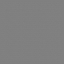

-


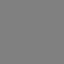

-


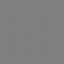

-


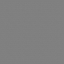

-


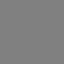

-


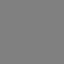

-


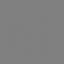

-


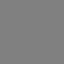

-


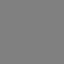

-


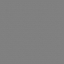

-


In [ ]:
from PIL import Image

for i in range(0,10):
    im = Image.fromarray(X_train[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    display(im)

    im = Image.fromarray(Ys[i])
    if im.mode != 'RGB':
        im = im.convert('RGB')
    display(im)
    print("-")

#### WGAN

In [ ]:
import tensorflow as tf
from keras.layers import Dense, Flatten, Conv2D,Conv2DTranspose, BatchNormalization

def critic(x, is_training=True, reuse_variables=True):
    with tf.variable_scope('critic', reuse=reuse_variables):
        conv_0 = Conv2D(filters=128,
                                  kernel_size=(4, 4),
                                  strides=(2, 2),
                                  padding='same')(x)

        conv_1 = Conv2D(filters=256,
                                  kernel_size=(4, 4),
                                  strides=(2, 2),
                                  padding='same')(tf.nn.leaky_relu(conv_0))

        b_conv_1 = BatchNormalization()(conv_1, training=is_training)

        conv_2 = Conv2D(filters=512,
                                  kernel_size=(4, 4),
                                  strides=(2, 2),
                                  padding='same')(tf.nn.leaky_relu(b_conv_1))

        b_conv_2 = BatchNormalization()(conv_2, training=is_training)

        conv_3 = Conv2D(filters=1024,
                                  kernel_size=(4, 4),
                                  strides=(2, 2),
                                  padding='same')(tf.nn.leaky_relu(b_conv_2))

        b_conv_3 = BatchNormalization()(conv_3, training=is_training)

        conv_4 = Conv2D(filters=1,
                                  kernel_size=(4, 4),
                                  padding='valid')(tf.nn.leaky_relu(b_conv_3))

        return conv_4

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

graph = tf.Graph()

with graph.as_default():
    input_x = tf.placeholder(tf.float32, shape=(None, width, height, 1))
    input_z = tf.placeholder(tf.float32, shape=(None, code_length))
    is_training = tf.placeholder(tf.bool)

    gen = generator(z=tf.reshape(input_z, (-1, 1, 1, code_length)), is_training=is_training)

    r_input_x = tf.image.resize_images(images=input_x, size=(64, 64))

    crit_1_l = critic(x=r_input_x, is_training=is_training, reuse_variables=False)
    crit_2_l = critic(x=gen, is_training=is_training, reuse_variables=True)

    loss_c = tf.reduce_mean(crit_2_l - crit_1_l)
    loss_g = tf.reduce_mean(-crit_2_l)

    variables_g = [variable for variable in tf.trainable_variables() if variable.name.startswith('generator')]
    variables_c = [variable for variable in tf.trainable_variables() if variable.name.startswith('critic')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        optimizer_c = tf.train.AdamOptimizer(0.00005, beta1=0.5, beta2=0.9).minimize(loss=loss_c, var_list=variables_c)

        with tf.control_dependencies([optimizer_c]):
            training_step_c = tf.tuple(tensors=[tf.assign(variable, tf.clip_by_value(variable, -0.01, 0.01))
                                                for variable in variables_c])

        training_step_g = tf.train.AdamOptimizer(0.00005, beta1=0.5, beta2=0.9).minimize(loss=loss_g, var_list=variables_g)


In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

nb_epochs = 200
nb_critic = 5
batch_size = 64
nb_iterations = int(nb_samples / batch_size)

session = tf.InteractiveSession(graph=graph)
tf.global_variables_initializer().run()

samples_range = np.arange(nb_samples)

for e in range(nb_epochs):
    c_losses = []
    g_losses = []

    for i in range(nb_iterations):
        for j in range(nb_critic):
            print(i,"/",nb_iterations, "-",j,"/", nb_critic)
            Xi = np.random.choice(samples_range, size=batch_size)
            X = np.expand_dims(X_train[Xi], axis=3)
            Z = np.random.uniform(-1.0, 1.0, size=(batch_size, code_length)).astype(np.float32)

            _, c_loss = session.run([training_step_c, loss_c],
                                    feed_dict={
                                        input_x: X,
                                        input_z: Z,
                                        is_training: True
                                    })
            c_losses.append(c_loss)

        Z = np.random.uniform(-1.0, 1.0, size=(batch_size, code_length)).astype(np.float32)

        _, g_loss = session.run([training_step_g, loss_g],
                                feed_dict={
                                    input_x: np.zeros(shape=(batch_size, width, height, 1)),
                                    input_z: Z,
                                    is_training: True
                                })

        g_losses.append(g_loss)

    print('Epoch {}) Avg. critic loss: {} - Avg. generator loss: {}'.format(e + 1, np.mean(c_losses), np.mean(g_losses)))


0 / 78 0 / 5
0 / 78 1 / 5
0 / 78 2 / 5


KeyboardInterrupt: 

In [ ]:
Z = np.random.uniform(-1.0, 1.0, size=(50, code_length)).astype(np.float32)

Ys = session.run([gen],
                 feed_dict={
                     input_z: Z,
                     is_training: False
                })

Ys = np.squeeze((Ys[0] + 1.0) * 0.5 * 255.0).astype(np.uint8)


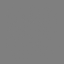

-


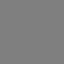

-


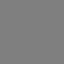

-


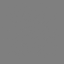

-


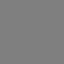

-


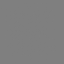

-


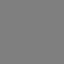

-


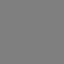

-


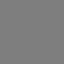

-


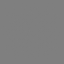

-


In [ ]:
from PIL import Image

for i in range(0,10):
    im = Image.fromarray(X_train[i] * 255.0)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    display(im)

    im = Image.fromarray(Ys[i])
    if im.mode != 'RGB':
        im = im.convert('RGB')
    display(im)
    print("-")